In [1]:
import numpy as np
import os
from einops import rearrange
import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
import time
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
# import plotly.express as px
# import plotly
# plotly.offline.init_notebook_mode(connected=True)
# import plotly.io as pio
# pio.renderers.default = 'iframe'
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import scipy.stats as st


In [2]:
num_heads = 40
num_layers = 40
vector_direction_dir = 'vgr/pca_TEST_val'
head_dir = 'vgr/head_TEST/train'
k = 3

In [3]:
pca_direction_all = []
pca_values_all = []
for subdir in os.listdir(vector_direction_dir):
    if '1' in subdir:
        load_dir = os.path.join(vector_direction_dir, subdir)
        pca_directions = np.load(os.path.join(load_dir, f'pca_direction_1000.npy'))
        pca_directions = rearrange(pca_directions, '(l h) s d -> l h s d', h=num_heads)
        pca_direction_all.append(pca_directions)

        pca_values = np.load(os.path.join(load_dir, f'pca_values_1000.npy')).squeeze()
        pca_values = rearrange(pca_values, '(l h) d -> l h d', h=num_heads)
        pca_values = np.mean(pca_values, axis =-1)
        pca_values_all.append(pca_values)

In [4]:
def combine_qr(head_directions):
    Q, _ = np.linalg.qr(head_directions.T)
    basis = Q.T
    return np.mean(basis, axis=0)

def combine(direction_set):
    combined_direction = []
    for l in range(num_layers):
        for h in range(num_heads):
            head_all = []
            for direction_set in pca_direction_all:
                head_all.append(direction_set[l,h,:,:])
            head_all = np.vstack(head_all)
            combined_head_value = combine_qr(head_all)
            if len(combined_head_value.shape) == 1:
                combined_head_value = combined_head_value.reshape(1,-1)
            combined_direction.append(combined_head_value)
    return np.array(combined_direction)

def get_top_heads(per_head_component, k):
    top_component_val = np.argsort(per_head_component.reshape(num_heads*num_layers))[::-1][:k]
    top_heads = [flattened_idx_to_layer_head(idx, num_heads) for idx in top_component_val]
    return top_heads

def get_bottom_heads(per_head_component, k):
    top_component_val = np.argsort(per_head_component.reshape(num_heads*num_layers))[:k]
    top_heads = [flattened_idx_to_layer_head(idx, num_heads) for idx in top_component_val]
    return top_heads
    
def flattened_idx_to_layer_head(flattened_idx, num_heads):
    return flattened_idx // num_heads, flattened_idx % num_heads

In [5]:
pca_direction_combined = combine(pca_direction_all)
pca_direction_combined = rearrange(pca_direction_combined, '(l h) s d -> l h s d', h=num_heads)

In [6]:
per_head_component_values = np.mean(np.dstack(pca_values_all), axis=-1)
top_heads = get_top_heads(per_head_component_values, k)

In [7]:
top_heads

[(10, 12), (10, 6), (38, 26)]

In [8]:
pca_direction_combined.shape

(40, 40, 1, 128)

In [9]:
combined_direction_top = pca_direction_combined[top_heads[0][0], top_heads[0][1], :, :]

In [10]:
combined_direction_top.shape

(1, 128)

In [11]:
yes_head_all = np.load(os.path.join(head_dir, 'yes_1', f'head_1000.npy'))
yes_head_all = rearrange(yes_head_all, 'b l (h d) -> b l h d', h = num_heads)

no_head_all = np.load(os.path.join(head_dir, 'no_1', f'head_1000.npy'))
no_head_all = rearrange(no_head_all, 'b l (h d) -> b l h d', h = num_heads)
no_head_all.shape

(1000, 40, 40, 128)

In [12]:
bottom_heads = get_bottom_heads(per_head_component_values, k)

In [13]:
top_heads

[(10, 12), (10, 6), (38, 26)]

In [21]:
def plot_kde(top_heads):
    fig, axes = plt.subplots(1, len(top_heads), figsize=(10, 3))
    for i, h in enumerate(top_heads):
        yes_top = yes_head_all[:, h[0], h[1], :]
        no_top = no_head_all[:, h[0], h[1], :]

        yes_first = yes_top[:500, :]
        yes_last = yes_top[500:, :]
        no_first = no_top[500:, :]
        no_last = no_top[:500, :]
        
        pca = PCA(n_components=2)
        components =  pca.fit_transform(np.vstack((yes_first, yes_last, no_first, no_last)))
        # Q, _ = np.linalg.qr(components)
        # basis = Q
        # print(basis.shape)
        df={}
        df['pc_1'] = components[:,0]
        df['pc_2'] = components[:,1]
        y = ["first" for i in range(500)]
        y.extend(['last' for i in range(500)])
        y.extend(['first' for i in range(500)])
        y.extend(['last' for i in range(500)])
        df['bias'] = y
        df = pd.DataFrame(df) 
        
        sns.kdeplot(data=df, x='pc_1', y='pc_2',hue='bias',
            fill=False, ax=axes[i])

        axes[i].set_xlabel('PC1')
        axes[i].set_ylabel('PC2')
        axes[i].set_yticks([])
        axes[i].set_title(f'head {h}')
        # axes[i].set_title(f"head {h}")
        # if i > 0:
            # axes[i].get_legend().remove()

    # handles, labels = axes[i].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='center', ncol=2, bbox_to_anchor=(0.8, 1.1))
    # fig.tight_layout()
    # fig.suptitle('VG Relation')
        # axes[i].legend()

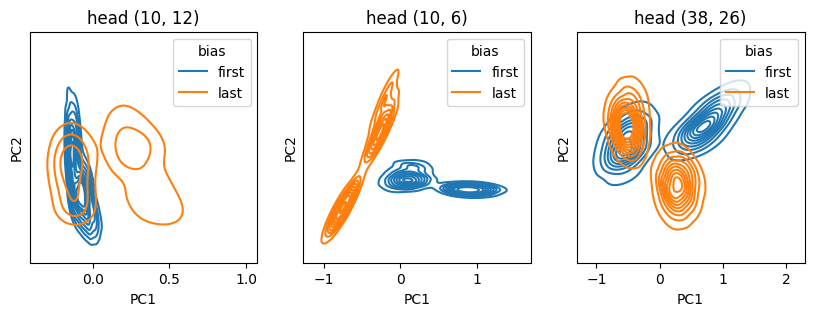

In [22]:
plot_kde(top_heads)